In [16]:
import IPython
import numpy as np
import tvm
from tvm import relax
from tvm.ir.module import IRModule
from tvm.script import relax as R
from tvm.script import tir   as T

In [17]:
import torch
import torchvision

test_data = torchvision.datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor()
)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True)
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

img, label = next(iter(test_loader))
img = img.reshape(1, 28, 28).numpy()

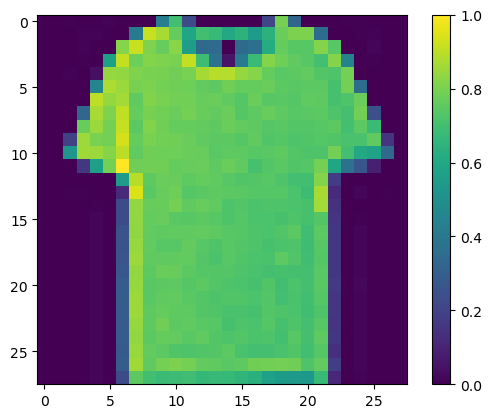

Class: T-shirt/top


In [18]:
import matplotlib.pyplot as plt

img, label = next(iter(test_loader))
img = img.reshape(1, 28, 28).numpy()

plt.figure()
plt.imshow(img[0])
plt.colorbar()
plt.grid(False)
plt.show()
print("Class:", class_names[label[0]])

# 模型参数

In [19]:
# Hide outputs
!wget https://github.com/mlc-ai/web-data/raw/main/models/fasionmnist_mlp_params.pkl

--2024-08-01 08:26:36--  https://github.com/mlc-ai/web-data/raw/main/models/fasionmnist_mlp_params.pkl
Resolving github.com (github.com)... 140.82.116.3
Connecting to github.com (github.com)|140.82.116.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mlc-ai/web-data/main/models/fasionmnist_mlp_params.pkl [following]
--2024-08-01 08:26:36--  https://raw.githubusercontent.com/mlc-ai/web-data/main/models/fasionmnist_mlp_params.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407396 (398K) [application/octet-stream]
Saving to: ‘fasionmnist_mlp_params.pkl.2’

fasionmnist_mlp_par 100%[===================>] 397.85K  --.-KB/s    in 0.04s   

2024-08-01 08:26:36 (10.5 MB/s) - ‘fasionmnist_mlp_params

# 模型实现

In [20]:
### numpy 

def numpy_mlp(data, w0, b0, w1, b1):
    lv0 = data @ w0.T + b0
    lv1 = np.maximum(lv0, 0)
    lv2 = lv1 @ w1.T + b1
    return lv2

In [21]:
import pickle as pkl

mlp_params = pkl.load(open("fasionmnist_mlp_params.pkl", "rb"))
res = numpy_mlp(img.reshape(1, 784),
                mlp_params["w0"],
                mlp_params["b0"],
                mlp_params["w1"],
                mlp_params["b1"])
print(res)
pred_kind = res.argmax(axis=1)
print(pred_kind)
print("NumPy-MLP Prediction:", class_names[pred_kind[0]])

[[ 27.92387   -14.121379   -5.5543213 -13.672167  -41.59612   -38.36612
   14.641289  -49.75344   -24.988636  -54.4973   ]]
[0]
NumPy-MLP Prediction: T-shirt/top


In [22]:
## 底层 numpy 

def lnumpy_linear0(X: np.ndarray, W: np.ndarray, B: np.ndarray, Z: np.ndarray):
    Y = np.empty((1, 128), dtype="float32")
    for i in range(1):
        for j in range(128):
            for k in range(784):
                if k == 0:
                    Y[i, j] = 0
                Y[i, j] = Y[i, j] + X[i, k] * W[j, k]

    for i in range(1):
        for j in range(128):
            Z[i, j] = Y[i, j] + B[j]


def lnumpy_relu0(X: np.ndarray, Y: np.ndarray):
     for i in range(1):
        for j in range(128):
            Y[i, j] = np.maximum(X[i, j], 0)

def lnumpy_linear1(X: np.ndarray, W: np.ndarray, B: np.ndarray, Z: np.ndarray):
    Y = np.empty((1, 10), dtype="float32")
    for i in range(1):
        for j in range(10):
            for k in range(128):
                if k == 0:
                    Y[i, j] = 0
                Y[i, j] = Y[i, j] + X[i, k] * W[j, k]

    for i in range(1):
        for j in range(10):
            Z[i, j] = Y[i, j] + B[j]


def lnumpy_mlp(data, w0, b0, w1, b1):
    lv0 = np.empty((1, 128), dtype="float32")
    lnumpy_linear0(data, w0, b0, lv0)

    lv1 = np.empty((1, 128), dtype="float32")
    lnumpy_relu0(lv0, lv1)

    out = np.empty((1, 10), dtype="float32")
    lnumpy_linear1(lv1, w1, b1, out)
    return out

result =lnumpy_mlp(
    img.reshape(1, 784),
    mlp_params["w0"],
    mlp_params["b0"],
    mlp_params["w1"],
    mlp_params["b1"])

pred_kind = result.argmax(axis=1)
print("Low-level Numpy MLP Prediction:", class_names[pred_kind[0]])

Low-level Numpy MLP Prediction: T-shirt/top


In [23]:
## TVM 实现 

@tvm.script.ir_module
class MyModule:
    @T.prim_func
    def relu0(x: T.handle, y: T.handle):
        n = T.int64()
        X = T.match_buffer(x, (1, n), "float32")
        Y = T.match_buffer(y, (1, n), "float32")
        for i, j in T.grid(1, n):
            with T.block("Y"):
                vi, vj = T.axis.remap("SS", [i, j])
                Y[vi, vj] = T.max(X[vi, vj], T.float32(0))

    @T.prim_func
    def linear0(x: T.handle,
                w: T.handle,
                b: T.handle,
                z: T.handle):
        m, n, k = T.int64(), T.int64(), T.int64()
        X = T.match_buffer(x, (1, m), "float32")
        W = T.match_buffer(w, (n, m), "float32")
        B = T.match_buffer(b, (n, ), "float32")
        Z = T.match_buffer(z, (1, n), "float32")
        Y = T.alloc_buffer((1, n), "float32")
        for i, j, k in T.grid(1, n, m):
            with T.block("Y"):
                vi, vj, vk = T.axis.remap("SSR", [i, j, k])
                with T.init():
                    Y[vi, vj] = T.float32(0)
                Y[vi, vj] = Y[vi, vj] + X[vi, vk] * W[vj, vk]
        for i, j in T.grid(1, n):
            with T.block("Z"):
                vi, vj = T.axis.remap("SS", [i, j])
                Z[vi, vj] = Y[vi, vj] + B[vj]

    @R.function
    def main(x  : R.Tensor((1, "m"),   "float32"),
             w0 : R.Tensor(("n", "m"), "float32"),
             b0 : R.Tensor(("n", ),    "float32"),
             w1 : R.Tensor(("k", "n"), "float32"),
             b1 : R.Tensor(("k", ),    "float32")):
        m, n, k = T.int64(), T.int64(), T.int64()
        with R.dataflow():
            # call_dps_packed 接受一个元函数 (prim_func) 的输入列表，并分配一个输出张量res，然后将输入和输出传递给prim_func。
            # why ? 输入和输出在外部显式分配并传递给底层元函数。保证了内存分配没有冗余 赞 ！ 
            # 这里的关键思想是我们想要隐藏可能的分配或对函数的显式写入。 
            # 更正式的术语来说，我们希望函数是 pure 或 side-effect free。
            # 如果一个函数只从其输入中读取并通过其输出返回结果，它不会改变程序的其他部分（例如递增全局计数器），那么它是pure或side-effect free的。
            # dataflow block是我们标记程序计算图区域的一种方式。 具体来说，在dataflow block中，所有操作都需要side-effect free。
            lv0 = R.call_dps_packed("linear0", (x, w0, b0), R.Tensor((1, n), "float32"))
            lv1 = R.call_dps_packed("relu0", (lv0, ), R.Tensor((1, n), "float32"))
            out = R.call_dps_packed("linear0", (lv1, w1, b1), R.Tensor((1, k), "float32"))
            R.output(out)
        return out

In [24]:
IPython.display.Code(MyModule.script(), language="python")

# from tvm.script import ir as I
# from tvm.script import tir as T
# from tvm.script import relax as R

@I.ir_module
class Module:
    @T.prim_func
    def linear0(x: T.handle, w: T.handle, b: T.handle, z: T.handle):
        m = T.int64()
        X = T.match_buffer(x, (1, m))
        n = T.int64()
        W = T.match_buffer(w, (n, m))
        B = T.match_buffer(b, (n,))
        Z = T.match_buffer(z, (1, n))
        # with T.block("root"):
        Y = T.alloc_buffer((1, n))
        for i, j, k in T.grid(1, n, m):
            with T.block("Y"):
                vi, vj, vk = T.axis.remap("SSR", [i, j, k])
                T.reads(X[vi, vk], W[vj, vk])
                T.writes(Y[vi, vj])
                with T.init():
                    Y[vi, vj] = T.float32(0)
                Y[vi, vj] = Y[vi, vj] + X[vi, vk] * W[vj, vk]
        for i, j in T.grid(1, n):
            with T.block("Z"):
                vi, vj = T.axis.remap("SS", [i, j])
                T.reads(Y[vi, vj], B[vj])
                T.writes(Z[vi, vj])
                Z[vi, vj] = Y[vi, vj] + B[vj]

    @T.prim_func
    def relu0(x: T.handle, y: T.handle):
        n = T.int64()
        X = T.match_buffer(x, (1, n))
        Y = T.match_buffer(y, (1, n))
        # with T.block("root"):
        for i, j in T.grid(1, n):
            with T.block("Y"):
                vi, vj = T.axis.remap("SS", [i, j])
                T.reads(X[vi, vj])
                T.writes(Y[vi, vj])
                Y[vi, vj] = T.max(X[vi, vj], T.float32(0))

    @R.function
    def main(x: R.Tensor((1, "m"), dtype="float32"), w0: R.Tensor(("n", "m"), dtype="float32"), b0: R.Tensor(("n",), dtype="float32"), w1: R.Tensor(("k", "n"), dtype="float32"), b1: R.Tensor(("k",), dtype="float32")) -> R.Tensor((1, "k"), dtype="float32"):
        k = T.int64()
        m = T.int64()
        n = T.int64()
        with R.dataflow():
            lv0 = R.call_dps_packed("linear0", (x, w0, b0), out_sinfo=R.Tensor((1, n), dtype="float32"))
            lv1 = R.call_dps_packed("relu0", (lv0,), out_sinfo=R.Tensor((1, n), dtype="float32"))
            out = R.call_dps_packed("linear0", (lv1, w1, b1), out_sinfo=R.Tensor((1, k), dtype="float32"))
            R.output(out)
        return out

In [25]:
### 构建函数 

ex = relax.build(MyModule, target="llvm")
type(ex)

tvm.relax.vm_build.Executable

In [26]:
# 构建虚拟机环境

vm = relax.VirtualMachine(ex, tvm.cpu())  # 第二个参数指定运行环境 

data_nd = tvm.nd.array(img.reshape(1, 784))
nd_params = {k: tvm.nd.array(v) for k, v in mlp_params.items()}

nd_res = vm["main"](data_nd,
                    nd_params["w0"],
                    nd_params["b0"],
                    nd_params["w1"],
                    nd_params["b1"])
print(nd_res)

pred_kind = np.argmax(nd_res.numpy(), axis=1)
print("MyModule Prediction:", class_names[pred_kind[0]])

[[ 27.923868 -14.121378  -5.55432  -13.672164 -41.596104 -38.36612
   14.641288 -49.753433 -24.988628 -54.497295]]
MyModule Prediction: T-shirt/top


# 在环境中集成现有运行库

In [27]:
@tvm.script.ir_module
class MyModuleWithExternCall:
    @R.function
    def main(x: R.Tensor((1, "m"), "float32"),
             w0: R.Tensor(("n", "m"), "float32"),
             b0: R.Tensor(("n", ), "float32"),
             w1: R.Tensor(("k", "n"), "float32"),
             b1: R.Tensor(("k", ), "float32")):
        # block 0
        m, n, k = T.int64(), T.int64(), T.int64()
        with R.dataflow():
            lv0 = R.call_dps_packed("env.linear", (x, w0, b0), R.Tensor((1, n), "float32"))
            lv1 = R.call_dps_packed("env.relu", (lv0, ), R.Tensor((1, n), "float32"))
            out = R.call_dps_packed("env.linear", (lv1, w1, b1), R.Tensor((1, k), "float32"))
            R.output(out)
        return out

### 注册运行时函数 

In [29]:
@tvm.register_func("env.linear", override=True) # 调用 pytorch 实现
def torch_linear(x: tvm.nd.NDArray,
                 w: tvm.nd.NDArray,
                 b: tvm.nd.NDArray,
                 out: tvm.nd.NDArray):
    x_torch = torch.from_dlpack(x)
    w_torch = torch.from_dlpack(w)
    b_torch = torch.from_dlpack(b)
    out_torch = torch.from_dlpack(out)
    torch.mm(x_torch, w_torch.T, out=out_torch)
    torch.add(out_torch, b_torch, out=out_torch)

@tvm.register_func("env.relu", override=True)
def lnumpy_relu(x: tvm.nd.NDArray,
                out: tvm.nd.NDArray):
    x_torch = torch.from_dlpack(x)     # from_dlpack 将 TVM NDArray 转换为 torch NDArray
    out_torch = torch.from_dlpack(out) # from_dlpack 将 TVM NDArray 转换为 torch NDArray
    torch.maximum(x_torch, torch.Tensor([0.0]), out=out_torch)

In [30]:
ex = relax.build(MyModuleWithExternCall, target="llvm")
vm = relax.VirtualMachine(ex, tvm.cpu())

nd_res = vm["main"](data_nd,
                    nd_params["w0"],
                    nd_params["b0"],
                    nd_params["w1"],
                    nd_params["b1"])

pred_kind = np.argmax(nd_res.numpy(), axis=1)
print("MyModuleWithExternCall Prediction:", class_names[pred_kind[0]])

MyModuleWithExternCall Prediction: T-shirt/top


## mixing TensorIR code and libraries 

In [31]:
@tvm.script.ir_module
class MyModuleMixture:
    @T.prim_func
    def linear0(x: T.handle,
                w: T.handle,
                b: T.handle,
                z: T.handle):
        m, n, k = T.int64(), T.int64(), T.int64()
        X = T.match_buffer(x, (1, m), "float32")
        W = T.match_buffer(w, (n, m), "float32")
        B = T.match_buffer(b, (n, ), "float32")
        Z = T.match_buffer(z, (1, n), "float32")
        Y = T.alloc_buffer((1, n), "float32")
        for i, j, k in T.grid(1, n, m):
            with T.block("Y"):
                vi, vj, vk = T.axis.remap("SSR", [i, j, k])
                with T.init():
                    Y[vi, vj] = T.float32(0)
                Y[vi, vj] = Y[vi, vj] + X[vi, vk] * W[vj, vk]
        for i, j in T.grid(1, n):
            with T.block("Z"):
                vi, vj = T.axis.remap("SS", [i, j])
                Z[vi, vj] = Y[vi, vj] + B[vj]

    @R.function
    def main(x: R.Tensor((1, "m"), "float32"),
             w0: R.Tensor(("n", "m"), "float32"),
             b0: R.Tensor(("n", ), "float32"),
             w1: R.Tensor(("k", "n"), "float32"),
             b1: R.Tensor(("k", ), "float32")):
        m, n, k = T.int64(), T.int64(), T.int64()
        with R.dataflow():
            lv0 = R.call_dps_packed("linear0", (x, w0, b0), R.Tensor((1, n), "float32"))          ### TensorIR code
            lv1 = R.call_dps_packed("env.relu", (lv0, ), R.Tensor((1, n), "float32"))             ### library
            out = R.call_dps_packed("env.linear", (lv1, w1, b1), R.Tensor((1, k), "float32"))     ### library
            R.output(out)
        return out

In [32]:
ex = relax.build(MyModuleMixture, target="llvm")
vm = relax.VirtualMachine(ex, tvm.cpu())

nd_res = vm["main"](data_nd,
                    nd_params["w0"],
                    nd_params["b0"],
                    nd_params["w1"],
                    nd_params["b1"])

pred_kind = np.argmax(nd_res.numpy(), axis=1)
print("MyModuleMixture Prediction:", class_names[pred_kind[0]])

MyModuleMixture Prediction: T-shirt/top


## 参数绑定

In [33]:
MyModuleWithParams = relax.transform.BindParams("main", nd_params)(MyModuleMixture)  ## 相当于 C++ 的 binding ! 
IPython.display.Code(MyModuleWithParams.script(), language="python")

# from tvm.script import ir as I
# from tvm.script import tir as T
# from tvm.script import relax as R

@I.ir_module
class Module:
    @T.prim_func
    def linear0(x: T.handle, w: T.handle, b: T.handle, z: T.handle):
        m = T.int64()
        X = T.match_buffer(x, (1, m))
        n = T.int64()
        W = T.match_buffer(w, (n, m))
        B = T.match_buffer(b, (n,))
        Z = T.match_buffer(z, (1, n))
        # with T.block("root"):
        Y = T.alloc_buffer((1, n))
        for i, j, k in T.grid(1, n, m):
            with T.block("Y"):
                vi, vj, vk = T.axis.remap("SSR", [i, j, k])
                T.reads(X[vi, vk], W[vj, vk])
                T.writes(Y[vi, vj])
                with T.init():
                    Y[vi, vj] = T.float32(0)
                Y[vi, vj] = Y[vi, vj] + X[vi, vk] * W[vj, vk]
        for i, j in T.grid(1, n):
            with T.block("Z"):
                vi, vj = T.axis.remap("SS", [i, j])
                T.reads(Y[vi, vj], B[vj])
                T.writes(Z[vi, vj])
                Z[vi, vj] = Y[vi, vj] + B[vj]

    @R.function
    def main(x: R.Tensor((1, 784), dtype="float32")) -> R.Tensor((1, 10), dtype="float32"):
        with R.dataflow():
            lv0 = R.call_dps_packed("linear0", (x, metadata["relax.expr.Constant"][0], metadata["relax.expr.Constant"][1]), out_sinfo=R.Tensor((1, 128), dtype="float32"))
            lv1 = R.call_dps_packed("env.relu", (lv0,), out_sinfo=R.Tensor((1, 128), dtype="float32"))
            out = R.call_dps_packed("env.linear", (lv1, metadata["relax.expr.Constant"][2], metadata["relax.expr.Constant"][3]), out_sinfo=R.Tensor((1, 10), dtype="float32"))
            R.output(out)
        return out

# Metadata omitted. Use show_meta=True in script() method to show it.

In [36]:
ex = relax.build(MyModuleWithParams, target="llvm")
vm = relax.VirtualMachine(ex, tvm.cpu())

nd_res = vm["main"](data_nd)

pred_kind = np.argmax(nd_res.numpy(), axis=1)
print("MyModuleWithParams Prediction:", class_names[pred_kind[0]])

MyModuleWithParams Prediction: T-shirt/top
